In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
splits = ['train[:70%]', 'train[70%:]']

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=splits,
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Completed...: 100%|██████████| 1/1 [00:50<00:00, 50.53s/ url]


Dataset tf_flowers downloaded and prepared to C:\Users\tuest\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [4]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = len(training_set)
num_validation_examples = len(validation_set)

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [5]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [6]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [7]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [8]:
feature_extractor.trainable = False

In [10]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 147s 2s/step - loss: 0.7428 - accuracy: 0.7415 - val_loss: 0.4389 - val_accuracy: 0.8547
Epoch 2/10
81/81 [==============================] - 124s 2s/step - loss: 0.3797 - accuracy: 0.8727 - val_loss: 0.3529 - val_accuracy: 0.8837
Epoch 3/10
81/81 [==============================] - 103s 1s/step - loss: 0.2984 - accuracy: 0.9031 - val_loss: 0.3319 - val_accuracy: 0.8865
Epoch 4/10
81/81 [==============================] - 95s 1s/step - loss: 0.2481 - accuracy: 0.9249 - val_loss: 0.2991 - val_accuracy: 0.9010
Epoch 5/10
81/81 [==============================] - 94s 1s/step - loss: 0.2162 - accuracy: 0.9377 - val_loss: 0.2909 - val_accuracy: 0.8992
Epoch 6/10
81/81 [==============================] - 93s 1s/step - loss: 0.1921 - accuracy: 0.9459 - val_loss: 0.2843 - val_accuracy: 0.9037
Epoch 7/10
81/81 [==============================] - 95s 1s/step - loss: 0.1683 - accuracy: 0.9568 - val_loss: 0.2877 - val_accuracy: 0.8965
Epoch 8/10
81/81 

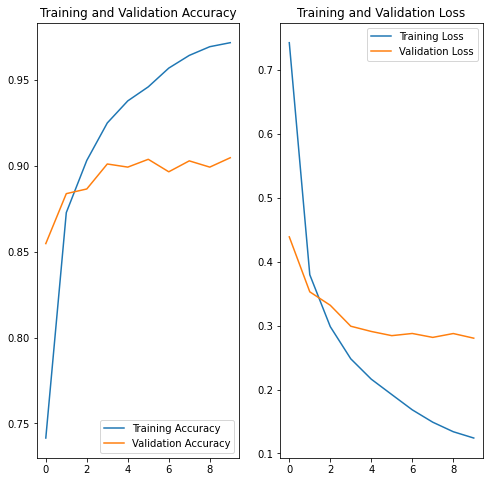

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [15]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [16]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['daisy' 'tulips' 'tulips' 'dandelion' 'dandelion' 'daisy' 'tulips'
 'roses' 'dandelion' 'daisy' 'sunflowers' 'roses' 'roses' 'sunflowers'
 'sunflowers' 'tulips' 'tulips' 'tulips' 'sunflowers' 'daisy' 'daisy'
 'sunflowers' 'sunflowers' 'dandelion' 'roses' 'daisy' 'roses' 'tulips'
 'sunflowers' 'tulips' 'sunflowers' 'sunflowers']


In [17]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [1 2 2 0 0 1 2 4 0 1 3 4 4 3 3 2 2 2 3 1 1 3 3 0 4 1 4 2 3 2 3 3]
Predicted labels:  [1 2 2 0 0 1 2 4 0 1 3 4 4 3 3 2 2 2 3 1 1 3 3 0 4 1 4 2 3 2 3 3]


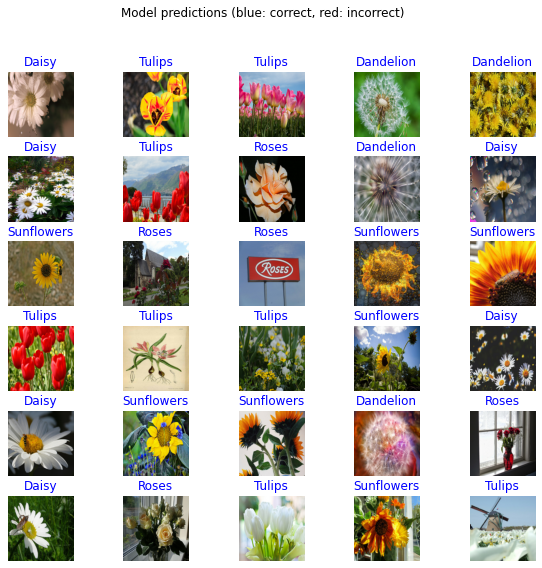

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")